# COMP5329 A1

Download data from these links. You can run it on **ANY** machine.

**Important!**


If you somehow get 403 Forbidden after running the !wget command, please try "disconnect and delete runtime" and try run again! If it still does not work, I am afraid that you will need to load the files by yourself.

In [1]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=185Z7nQyfNtFQe9IVjxEAsFTrP9uTQQZs' -O testdata.npy
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1d6SLS29EbPC3U2X9hXDGDG3ItWBiCq2u' -O testlabel.npy
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1d0TraQylOVvWimMy-BILunZo1jnBZnb2' -O traindata.npy
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1oJVIMAc2gy9YcQiRmA7nXxTYFYwxMZ03' -O trainlabel.npy
import numpy as np
testdata = np.load('testdata.npy')
testlabel = np.load('testlabel.npy')
traindata = np.load('traindata.npy')
trainlabel = np.load('trainlabel.npy')

--2023-04-02 04:28:16--  https://drive.google.com/uc?export=download&id=185Z7nQyfNtFQe9IVjxEAsFTrP9uTQQZs
Resolving drive.google.com (drive.google.com)... 74.125.137.100, 74.125.137.139, 74.125.137.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.137.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-5o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vmksae9usvj9afg6se1b90n27ad025b6/1680409650000/03524362754814942383/*/185Z7nQyfNtFQe9IVjxEAsFTrP9uTQQZs?e=download&uuid=5c31c8f5-f3b4-4e3e-9bdc-ea8e2189632e [following]
--2023-04-02 04:28:17--  https://doc-14-5o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vmksae9usvj9afg6se1b90n27ad025b6/1680409650000/03524362754814942383/*/185Z7nQyfNtFQe9IVjxEAsFTrP9uTQQZs?e=download&uuid=5c31c8f5-f3b4-4e3e-9bdc-ea8e2189632e
Resolving doc-14-5o-docs.googleusercontent.com (doc-14-5o-docs.googleusercontent.com)... 142.251.2.132, 2607:f

See what is the shape of our data.

In [2]:
print(traindata.shape)
print(trainlabel.shape)
print(testdata.shape)
print(testlabel.shape)

(50000, 128)
(50000, 1)
(10000, 128)
(10000, 1)


In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
traindata = scaler.fit_transform(traindata)
testdata = scaler.transform(testdata)

In [4]:
n_labels = len(np.unique(trainlabel))
trainlabel_one_hot = np.eye(n_labels)[trainlabel.reshape(-1)]
def one_hot_to_label(label_one_hot):
    return np.argmax(label_one_hot, axis=-1).reshape(-1)

In [5]:
class Activation:
    def __relu(self, x):
        return np.maximum(0, x)
    def __relu_deriv(self, a):
        return (a > 0).astype(int)
    def __softmax(self, x):
        x = np.atleast_2d(x)
        x -= np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    def __softmax_deriv(self, y, y_hat):
        return y_hat - y
    def __init__(self, activation="relu"):
        if activation == "relu":
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == "softmax":
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv

In [6]:
class HiddenLayer(object):
    def __init__(self,n_in,n_out,activation_last_layer="relu",activation="relu",W=None,b=None):
        self.input = None
        self.activation = Activation(activation).f
        self.activation_deriv = None
        if activation_last_layer:
            self.activation_deriv = Activation(activation_last_layer).f_deriv
        self.W = np.random.uniform(low=-np.sqrt(6.0 / (n_in + n_out)),high=np.sqrt(6.0 / (n_in + n_out)),size=(n_in, n_out))
        self.b = np.zeros(n_out,)
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
    def forward(self, input):
        lin_output = np.dot(input, self.W) + self.b
        self.output = (lin_output if self.activation is None else self.activation(lin_output))
        self.input = input
        return self.output
    def backward(self, delta, output_layer=False):
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = np.average(delta, axis=0)
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
        return delta

In [7]:
class MLP:
    def __init__(self, layer_sizes, activations=[None, "relu", "relu", "relu", "softmax"]):
        self.layers = []
        self.params = []
        self.activations = activations
        for i in range(len(layer_sizes) - 1):
            self.layers.append(HiddenLayer(layer_sizes[i], layer_sizes[i + 1], activations[i], activations[i + 1]))
    def forward(self, input_data):
        for layer in self.layers:
            output_data = layer.forward(input_data)
            input_data = output_data
        return output_data
    def cross_entropy_loss(self, y, y_hat):
        loss = -np.nansum(y * np.log(y_hat))
        loss = loss / y.shape[0]
        delta = Activation(self.activations[-1]).f_deriv(y, y_hat)
        return loss, delta
    def backward(self, delta):
        delta = self.layers[-1].backward(delta, output_layer=True)
        for layer in reversed(self.layers[:-1]):
            delta = layer.backward(delta)
    def update(self, learning_rate):
        for layer in self.layers:
            layer.W -= learning_rate * layer.grad_W
            layer.b -= learning_rate * layer.grad_b
    def fit(self, X, y, learning_rate, epochs, batch_size):
        X = np.array(X)
        y = np.array(y)
        training_loss, training_accuracy, testing_accuracy = [], [], []
        total_samples = X.shape[0]
        num_batches = int(np.ceil(total_samples / batch_size))
        for epoch in range(epochs):
            loss = np.zeros(num_batches)
            current_position = 0
            for batch_number in range(num_batches):
                end = min(current_position + batch_size, X.shape[0])
                X_batch, y_batch = X[current_position:end, :], y[current_position:end]
                y_hat = self.forward(X_batch)
                loss[batch_number], delta = self.cross_entropy_loss(y_batch, y_hat)
                self.backward(delta)
                self.update(learning_rate)
                current_position += batch_size
            train_accuracy = self.calculate_accuracy(traindata, trainlabel)
            test_accuracy = self.calculate_accuracy(testdata, testlabel)
            training_loss.append(np.mean(loss))
            training_accuracy.append(train_accuracy)
            testing_accuracy.append(test_accuracy)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {round(training_loss[-1], 2)}, Train Accuracy: {round(train_accuracy * 100, 2)}%, Test Accuracy: {round(test_accuracy * 100, 2)}%")
        return training_loss, training_accuracy, testing_accuracy
    def calculate_accuracy(self, X, y):
        predictions = self.predict(X)
        decoded_predictions = one_hot_to_label(predictions)
        num_correct_predictions = (decoded_predictions == y[:, 0]).sum()
        accuracy = num_correct_predictions / len(y)
        return accuracy
    def predict(self, x):
        x = np.array(x)
        output = [i for i in range(x.shape[0])]
        for i in np.arange(x.shape[0]):
            output[i] = self.forward(x[i, :])
        output = np.array(output)
        return output

In [8]:
LAYER_NEURONS = [128, 64, 10]
LAYER_ACTIVATION_FUNCS = [None, "relu", "softmax"]
LEARNING_RATE = 0.005
EPOCHS = 50
BATCH_SIZE = 64
nn = MLP(LAYER_NEURONS, LAYER_ACTIVATION_FUNCS)
result = nn.fit(traindata,trainlabel_one_hot,learning_rate=LEARNING_RATE,epochs=EPOCHS,batch_size=BATCH_SIZE)

Epoch 1/50, Loss: 1.73, Train Accuracy: 45.99%, Test Accuracy: 44.01%
Epoch 2/50, Loss: 1.54, Train Accuracy: 48.51%, Test Accuracy: 45.77%
Epoch 3/50, Loss: 1.51, Train Accuracy: 49.45%, Test Accuracy: 45.89%
Epoch 4/50, Loss: 1.49, Train Accuracy: 49.91%, Test Accuracy: 46.13%
Epoch 5/50, Loss: 1.48, Train Accuracy: 50.19%, Test Accuracy: 46.04%
Epoch 6/50, Loss: 1.47, Train Accuracy: 50.43%, Test Accuracy: 46.12%
Epoch 7/50, Loss: 1.47, Train Accuracy: 50.67%, Test Accuracy: 46.17%
Epoch 8/50, Loss: 1.46, Train Accuracy: 50.86%, Test Accuracy: 46.47%
Epoch 9/50, Loss: 1.46, Train Accuracy: 50.96%, Test Accuracy: 46.38%
Epoch 10/50, Loss: 1.45, Train Accuracy: 50.96%, Test Accuracy: 46.46%
Epoch 11/50, Loss: 1.45, Train Accuracy: 51.02%, Test Accuracy: 46.82%
Epoch 12/50, Loss: 1.45, Train Accuracy: 51.28%, Test Accuracy: 46.86%
Epoch 13/50, Loss: 1.44, Train Accuracy: 51.41%, Test Accuracy: 47.17%
Epoch 14/50, Loss: 1.44, Train Accuracy: 51.47%, Test Accuracy: 46.95%
Epoch 15/50, Lo

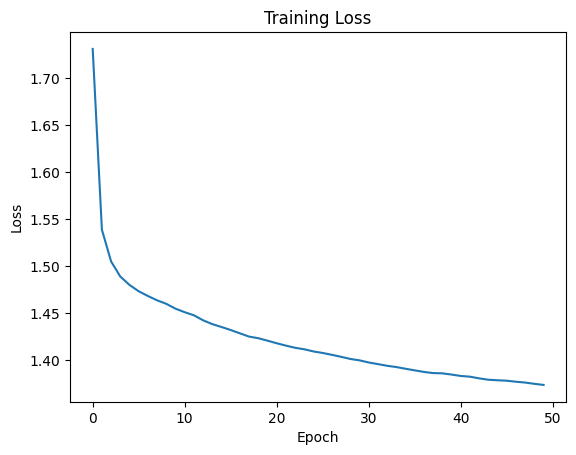

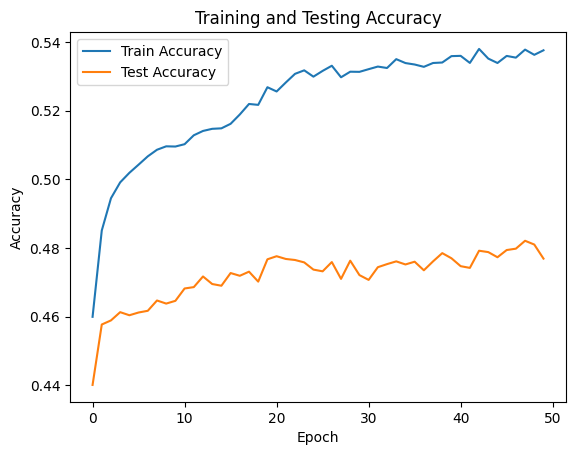

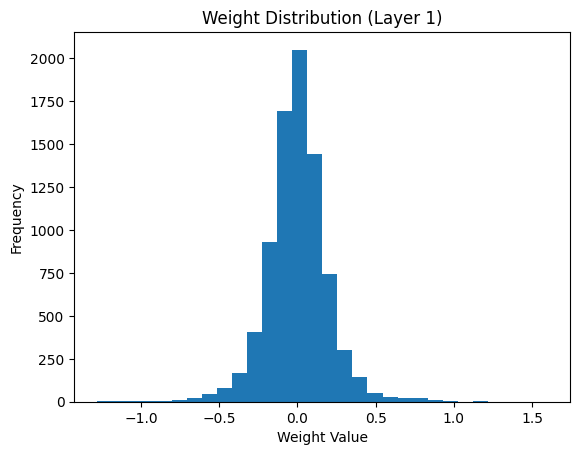

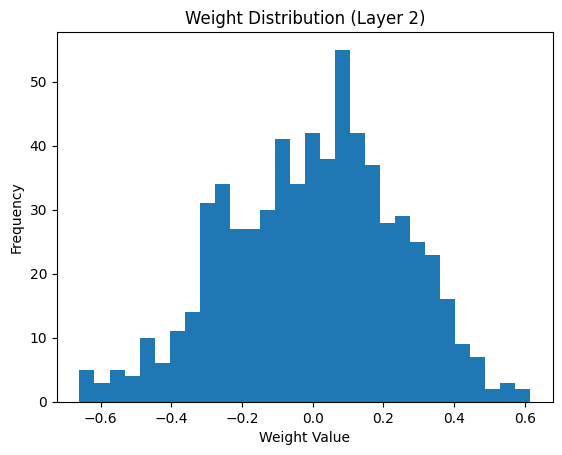

In [9]:
import matplotlib.pyplot as plt
# 训练误差
plt.plot(result[0])
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
# 训练精度和测试精度
plt.plot(result[1], label="Train Accuracy")
plt.plot(result[2], label="Test Accuracy")
plt.title("Training and Testing Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
# 层间权重分布
for i, layer in enumerate(nn.layers):
    plt.hist(layer.W.ravel(), bins=30)
    plt.title(f"Weight Distribution (Layer {i+1})")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.show()